In [1]:
import tensorflow as tf

import utils as u
import h5py
import itertools
from time import time
import os
import numpy as np
import random as rn


from sklearn.metrics import roc_curve,roc_auc_score,auc
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn import metrics

import keras 
from keras.models import load_model
from keras.callbacks import ModelCheckpoint,EarlyStopping
from keras import backend as K
from keras.layers import Dense, Dropout, Flatten,Conv2D, MaxPooling2D,Activation,BatchNormalization,LeakyReLU,UpSampling2D
from keras.utils import to_categorical,plot_model
from keras.models import Sequential
from keras.optimizers import Adam
from keras.callbacks import TensorBoard


import matplotlib.cm as cm
import matplotlib.pyplot as plt
%matplotlib inline


Using TensorFlow backend.


In [2]:
#for reproducibility in Python,numpy and Tensorflow we set their respective seeds as follows
os.environ['PYTHONHASHSEED']='0'
#np.random.seed(1)  ###For random problem region we don't set the numpy seed
rn.seed(2)
tf.set_random_seed(3)
session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)

#Force Tensorflow to use a single thread (this is recommended because it might be a cause of randomness)
sess=tf.Session(graph=tf.get_default_graph(),config=session_conf)
K.set_session(sess)

In [ ]:
"""A Custom Loss Function"""

#### [0.1,0.9] works well (acc > 0.99) but still no movement across the diagonal

x = np.array([[0.1,0.9]])
w = K.variable(x, name='w')

def customLoss(yTrue,yPred):
    return K.sum(K.dot(w, K.transpose(K.square(yTrue - yPred))))

In [18]:
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D,BatchNormalization
from keras.models import Model
from keras import backend as K

input_img = Input(shape=(input_shape))  # adapt this if using `channels_first` image data format

#x = Conv2D(86, (3, 3), padding='same')(input_img)
#x = BatchNormalization()(x)
#x = Activation('relu')(x)
#x = MaxPooling2D((2, 2), padding='same')(x)
#x = Conv2D(64, (3, 3), padding='same')(x)
#x = BatchNormalization()(x)
#x = Activation('relu')(x)
#x = MaxPooling2D((2, 2), padding='same')(x)
#x = Conv2D(32, (3, 3), padding='same')(x)
#x = BatchNormalization()(x)
#x = Activation('relu')(x)
#encoded = MaxPooling2D((2, 2), padding='same')(x)
#
#x = Conv2D(32, (3, 3), padding='same')(encoded)
#x = BatchNormalization()(x)
#x = Activation('relu')(x)
#x = UpSampling2D((2, 2))(x)
#x = Conv2D(64, (3, 3), padding='same')(x)
#x = BatchNormalization()(x)
#x = Activation('relu')(x)
#x = UpSampling2D((2, 2))(x)
#x = Conv2D(86, (3, 3), padding='same')(x)
#x = BatchNormalization()(x)
#x = Activation('relu')(x)
#x = UpSampling2D((2, 2))(x)
#decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='valid')(x)

autoencoder = Model(input_img, decoded)

autoencoder.compile(optimizer=customLoss, loss='mse')
#autoencoder.compile(optimizer='rmsprop', loss='mean_squared_error')

autoencoder.save('empty_AE.hdf5')
plot_model(autoencoder, to_file='AE_model.png')
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         (None, 74, 34, 1)         0         
_________________________________________________________________
conv2d_48 (Conv2D)           (None, 74, 34, 16)        160       
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 37, 17, 16)        0         
_________________________________________________________________
conv2d_49 (Conv2D)           (None, 37, 17, 8)         1160      
_________________________________________________________________
max_pooling2d_23 (MaxPooling (None, 19, 9, 8)          0         
_________________________________________________________________
conv2d_50 (Conv2D)           (None, 19, 9, 8)          584       
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 10, 5, 8)          0         
__________

Shape of regular image is:  (2997, 72, 32)
Shape of dead image is:  (2257, 72, 32)
Shape of hot image is:  (740, 72, 32)



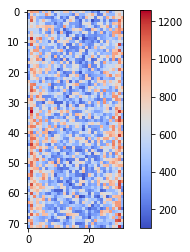

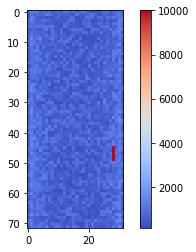

(5994, 72, 32)
X shape is:  (5994, 74, 34)
y shape is:  (5994,)
Xtrain.shape (1498, 74, 34)
Xtest.shape (3147, 74, 34)
ytrain.shape (1498,)
ytest.shape (3147,)
Printing labels and their corresponding images
-------------------
good


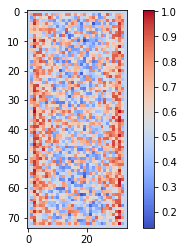

-------------------
bad


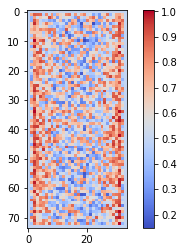

-------------------
bad


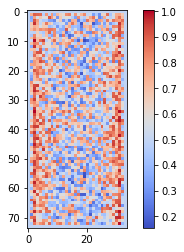

-------------------
bad


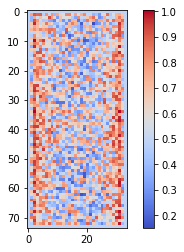

-------------------
bad


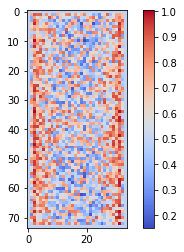

-------------------
bad


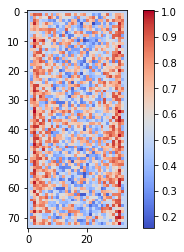

-------------------
bad


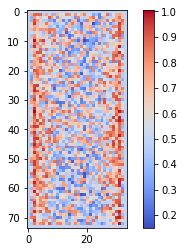

-------------------
bad


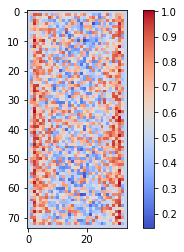

-------------------
bad


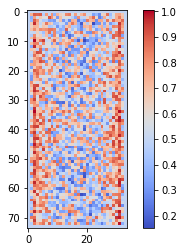

-------------------
bad


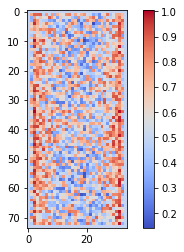

Xtrain.shape after if statement (1498, 74, 34, 1)
ytrain.shape after if statement 1498
Xval.shape after if statement  (1348, 74, 34, 1)
yval.shape after if statement 1348
Xtest.shape after if statement (3147, 74, 34, 1)
ytest.shape after if statement 3147
input_shape after if statement (74, 34, 1)


In [3]:
data_folder = '../../data'
file_name = 'HCAL_digi+rechit_occ.hdf5'
group = 'DigiTask_Occupancy_depth_depth1'

runs = ['306459','306138','306139']

data_sample= np.empty([0,72,84])
for run in runs:
    input_file=h5py.File(data_folder+'/'+'HCAL_digi+rechit_occ_run'+run+'.hdf5','r+')
    data_sample = np.concatenate((data_sample,np.array(input_file[group])),axis=0)
    
#print data_sample.shape

data_sample=data_sample[:,:,26:58]

#print data_sample.shape

average_occ = np.average(data_sample)

#print average_occ

for i in range(data_sample.shape[0]):
    for j in range(data_sample.shape[1]):
        for k in range(data_sample.shape[2]):
            if data_sample[i][j][k] == 0.0:
                #print 'yo', i, j, k
                data_sample[i][j][k] = average_occ
                
input_images=data_sample[:]
hotregion_image=[]
deadregion_image=[]

for k in input_images:
    
    yn = np.random.randint(4)
    
    xLen = np.random.randint(1,17)
    yLen = np.random.randint(1,17)
    
    a=np.random.randint(input_images.shape[2]-xLen)
    b=np.random.randint(input_images.shape[1]-yLen)
    
    xdim=(a,a+xLen)
    ydim=(b,b+yLen)
    
    #print 'xdim =', xdim
    #print 'ydim =', ydim
    
    if yn == 1:
        hotregion_image.append( u.hotregion(k,xdim,ydim))
    else:
        deadregion_image.append(u.killregion(k,xdim,ydim))
       
    
hotregion_image=np.array(hotregion_image)
deadregion_image=np.array(deadregion_image)

print "Shape of regular image is: ",input_images.shape
print "Shape of dead image is: " ,deadregion_image.shape
print "Shape of hot image is: " ,hotregion_image.shape

print ''
im=plt.imshow(input_images[1],cmap=cm.coolwarm)
plt.colorbar()
plt.show()
plt.clf()

########################################################################################

im=plt.imshow(hotregion_image[1],cmap=cm.coolwarm)
plt.colorbar()
plt.show()
plt.clf()

sample= np.append(data_sample,hotregion_image,axis=0)
sample= np.append(sample,deadregion_image,axis=0)
print sample.shape

X=np.copy(sample)

y=[]
yw=['good','bad']

for i in range(2):
    for k in range(input_images.shape[0]):
        y.append(yw[i])

y = np.array(y)
        
k=0
for img in X:
    X[k] = X[k] / np.max(img)
    k=k+1
for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        for k in range(X.shape[2]):
            val = X[i][j][k]
            X[i][j][k] = val*(1.75-(0.5/0.67)*val)
"""Add the padding layer of 0.5s"""
X_shape = X.shape
filler = np.ones((X_shape[0],X_shape[1]+2,X_shape[2]+2))/2
for i in range(X_shape[0]):
    for j in range(1,X_shape[1]+1):
        for k in range(1,X_shape[2]+1):
            filler[i][j][k] = X[i][j-1][k-1]
            
X = filler

##########################################################################################

#this is because I am only going to add the hot and dead region images

### Changed this to a 2 class problem, good and bad
#y[-1*input_images.shape[0]:]=1
#if you want it as integers leave this as it is
#if you would like it as a vector then do this

#y=to_categorical(y,2)

# convert class vectors to binary class matrices
#y_train = keras.utils.to_categorical(y_train, num_classes)
#y_test = keras.utils.to_categorical(y_test, num_classes)

print "X shape is: ",X.shape
print "y shape is: ",y.shape
# input image dimensions
img_rows, img_cols = X.shape[1],X.shape[2]


Xtrain = X[1:2997:2]
#ytrain = y[:700]
ytrain = y[1:2997:2]

Xt =  np.append(X[0:2996:2],X[2997:],axis=0)
#yt =  y[700:]
Yt = np.append(y[0:2996:2],y[2997:],axis=0)
#Xval, Xtest ,yval, ytest =train_test_split(Xt,yt,test_size=.4,random_state =5 )

Xval, Xtest ,yval, ytest =train_test_split(Xt,Yt,train_size =.3,random_state =5, )

print 'Xtrain.shape',Xtrain.shape
print 'Xtest.shape',Xtest.shape
print 'ytrain.shape',ytrain.shape
print 'ytest.shape',ytest.shape
print 'Printing labels and their corresponding images'
    
for k in range(10):
    print'-------------------'
    print ytest[k]
    im=plt.imshow(Xtrain[k],cmap=cm.coolwarm)
    plt.colorbar()
    plt.show()
    plt.clf()


Xtrain, Xval,input_shape= u.check_test_and_train_images_format(Xtrain, Xval, img_rows, img_cols)


if K.image_data_format() == 'channels_first':
        Xtest = Xtest.reshape(Xtest.shape[0], 1, img_rows, img_cols)
else:
        Xtest = Xtest.reshape(Xtest.shape[0], img_rows, img_cols, 1)


print 'Xtrain.shape after if statement',Xtrain.shape
print 'ytrain.shape after if statement',len(ytrain)#ytrain.shape
print 'Xval.shape after if statement ', Xval.shape
print 'yval.shape after if statement',  len(yval)#yval.shape
print 'Xtest.shape after if statement', Xtest.shape
print 'ytest.shape after if statement', len(ytest)#ytest.shape

print 'input_shape after if statement', input_shape

In [5]:
checkpointer = ModelCheckpoint(filepath='AE_random_best_model.hdf5', verbose=3, save_best_only=True)
earlystop= EarlyStopping(monitor='val_loss', min_delta=0, patience=30 ,verbose=1, mode='auto')
history=autoencoder.fit(Xtrain,Xtrain,epochs=300
                             ,verbose=1
                             ,validation_data=(Xval,Xval)
                             ,shuffle=True
                             ,callbacks=[checkpointer,earlystop])

Train on 1498 samples, validate on 1348 samples
Epoch 1/300
1498/1498 [==============================] - 12s 8ms/step - loss: 0.0394 - val_loss: 0.0663
Epoch 2/300
1498/1498 [==============================] - 12s 8ms/step - loss: 0.0352 - val_loss: 0.0658
Epoch 3/300
1498/1498 [==============================] - 11s 8ms/step - loss: 0.0331 - val_loss: 0.0607
Epoch 4/300
1498/1498 [==============================] - 12s 8ms/step - loss: 0.0323 - val_loss: 0.0604
Epoch 5/300
1498/1498 [==============================] - 12s 8ms/step - loss: 0.0319 - val_loss: 0.0602
Epoch 6/300
1498/1498 [==============================] - 11s 7ms/step - loss: 0.0318 - val_loss: 0.0623
Epoch 7/300
1498/1498 [==============================] - 12s 8ms/step - loss: 0.0317 - val_loss: 0.0594
Epoch 8/300
1498/1498 [==============================] - 12s 8ms/step - loss: 0.0315 - val_loss: 0.0601
Epoch 9/300
1498/1498 [==============================] - 12s 8ms/step - loss: 0.0315 - val_loss: 0.0619
Epoch 10/300
149

1498/1498 [==============================] - 11s 7ms/step - loss: 0.0295 - val_loss: 0.0581
Epoch 36/300
1498/1498 [==============================] - 11s 8ms/step - loss: 0.0294 - val_loss: 0.0586
Epoch 37/300
1498/1498 [==============================] - 12s 8ms/step - loss: 0.0294 - val_loss: 0.0571
Epoch 38/300
1498/1498 [==============================] - 12s 8ms/step - loss: 0.0292 - val_loss: 0.0586
Epoch 39/300
1498/1498 [==============================] - 11s 8ms/step - loss: 0.0292 - val_loss: 0.0564
Epoch 40/300
1498/1498 [==============================] - 12s 8ms/step - loss: 0.0290 - val_loss: 0.0576
Epoch 41/300
1498/1498 [==============================] - 12s 8ms/step - loss: 0.0290 - val_loss: 0.0561
Epoch 42/300
1498/1498 [==============================] - 12s 8ms/step - loss: 0.0289 - val_loss: 0.0581
Epoch 43/300
1498/1498 [==============================] - 12s 8ms/step - loss: 0.0287 - val_loss: 0.0562
Epoch 44/300
1498/1498 [==============================] - 13s 9ms/st

1498/1498 [==============================] - 11s 8ms/step - loss: 0.0260 - val_loss: 0.0548
Epoch 72/300
1498/1498 [==============================] - 11s 8ms/step - loss: 0.0260 - val_loss: 0.0559
Epoch 73/300
1498/1498 [==============================] - 12s 8ms/step - loss: 0.0260 - val_loss: 0.0535
Epoch 74/300
1498/1498 [==============================] - 12s 8ms/step - loss: 0.0258 - val_loss: 0.0546
Epoch 75/300
1498/1498 [==============================] - 13s 8ms/step - loss: 0.0257 - val_loss: 0.0533
Epoch 76/300
1498/1498 [==============================] - 12s 8ms/step - loss: 0.0257 - val_loss: 0.0533
Epoch 77/300
1498/1498 [==============================] - 12s 8ms/step - loss: 0.0255 - val_loss: 0.0551
Epoch 78/300
1498/1498 [==============================] - 12s 8ms/step - loss: 0.0254 - val_loss: 0.0535
Epoch 79/300
1498/1498 [==============================] - 13s 9ms/step - loss: 0.0253 - val_loss: 0.0547
Epoch 80/300
1498/1498 [==============================] - 14s 9ms/st

1498/1498 [==============================] - 11s 7ms/step - loss: 0.0228 - val_loss: 0.0527
Epoch 107/300
1498/1498 [==============================] - 12s 8ms/step - loss: 0.0226 - val_loss: 0.0531
Epoch 108/300
1498/1498 [==============================] - 11s 7ms/step - loss: 0.0227 - val_loss: 0.0516
Epoch 109/300
1498/1498 [==============================] - 11s 7ms/step - loss: 0.0225 - val_loss: 0.0530
Epoch 110/300
1498/1498 [==============================] - 11s 8ms/step - loss: 0.0225 - val_loss: 0.0514
Epoch 111/300
1498/1498 [==============================] - 11s 7ms/step - loss: 0.0225 - val_loss: 0.0525
Epoch 112/300
1498/1498 [==============================] - 11s 7ms/step - loss: 0.0223 - val_loss: 0.0528
Epoch 113/300
1498/1498 [==============================] - 12s 8ms/step - loss: 0.0222 - val_loss: 0.0534
Epoch 114/300
1498/1498 [==============================] - 12s 8ms/step - loss: 0.0222 - val_loss: 0.0535
Epoch 115/300
1498/1498 [==============================] - 1

1498/1498 [==============================] - 12s 8ms/step - loss: 0.0205 - val_loss: 0.0518
Epoch 143/300
1498/1498 [==============================] - 11s 8ms/step - loss: 0.0204 - val_loss: 0.0522
Epoch 144/300
1498/1498 [==============================] - 11s 7ms/step - loss: 0.0204 - val_loss: 0.0514
Epoch 145/300
1498/1498 [==============================] - 11s 7ms/step - loss: 0.0204 - val_loss: 0.0506
Epoch 146/300
1498/1498 [==============================] - 11s 7ms/step - loss: 0.0203 - val_loss: 0.0510
Epoch 147/300
1498/1498 [==============================] - 11s 7ms/step - loss: 0.0202 - val_loss: 0.0524
Epoch 148/300
1498/1498 [==============================] - 11s 7ms/step - loss: 0.0203 - val_loss: 0.0508
Epoch 149/300
1498/1498 [==============================] - 13s 8ms/step - loss: 0.0201 - val_loss: 0.0521
Epoch 150/300
1498/1498 [==============================] - 13s 8ms/step - loss: 0.0201 - val_loss: 0.0501
Epoch 151/300
1498/1498 [==============================] - 1

Epoch 180/300
1498/1498 [==============================] - 12s 8ms/step - loss: 0.0188 - val_loss: 0.0509
Epoch 181/300
1498/1498 [==============================] - 11s 7ms/step - loss: 0.0187 - val_loss: 0.0501
Epoch 182/300
1498/1498 [==============================] - 11s 7ms/step - loss: 0.0187 - val_loss: 0.0517
Epoch 183/300
1498/1498 [==============================] - 11s 8ms/step - loss: 0.0187 - val_loss: 0.0500
Epoch 184/300
1498/1498 [==============================] - 11s 8ms/step - loss: 0.0186 - val_loss: 0.0494
Epoch 185/300
1498/1498 [==============================] - 11s 7ms/step - loss: 0.0185 - val_loss: 0.0510
Epoch 186/300
1498/1498 [==============================] - 12s 8ms/step - loss: 0.0185 - val_loss: 0.0509
Epoch 187/300
1498/1498 [==============================] - 11s 7ms/step - loss: 0.0184 - val_loss: 0.0513
Epoch 188/300
1498/1498 [==============================] - 11s 7ms/step - loss: 0.0184 - val_loss: 0.0520
Epoch 189/300
1498/1498 [=====================

Epoch 218/300
1498/1498 [==============================] - 13s 8ms/step - loss: 0.0173 - val_loss: 0.0500
Epoch 219/300
1498/1498 [==============================] - 11s 7ms/step - loss: 0.0172 - val_loss: 0.0488
Epoch 220/300
1498/1498 [==============================] - 11s 7ms/step - loss: 0.0173 - val_loss: 0.0491
Epoch 221/300
1498/1498 [==============================] - 11s 7ms/step - loss: 0.0171 - val_loss: 0.0491
Epoch 222/300
1498/1498 [==============================] - 12s 8ms/step - loss: 0.0170 - val_loss: 0.0498
Epoch 223/300
1498/1498 [==============================] - 11s 7ms/step - loss: 0.0172 - val_loss: 0.0491
Epoch 224/300
1498/1498 [==============================] - 11s 7ms/step - loss: 0.0170 - val_loss: 0.0511
Epoch 225/300
1498/1498 [==============================] - 11s 7ms/step - loss: 0.0170 - val_loss: 0.0490
Epoch 226/300
1498/1498 [==============================] - 11s 7ms/step - loss: 0.0170 - val_loss: 0.0506
Epoch 227/300
1498/1498 [=====================

Epoch 256/300
1498/1498 [==============================] - 10s 7ms/step - loss: 0.0160 - val_loss: 0.0491
Epoch 257/300
1498/1498 [==============================] - 11s 7ms/step - loss: 0.0160 - val_loss: 0.0488
Epoch 258/300
1498/1498 [==============================] - 12s 8ms/step - loss: 0.0159 - val_loss: 0.0498
Epoch 259/300
1498/1498 [==============================] - 12s 8ms/step - loss: 0.0160 - val_loss: 0.0505
Epoch 260/300
1498/1498 [==============================] - 11s 7ms/step - loss: 0.0159 - val_loss: 0.0508
Epoch 261/300
1498/1498 [==============================] - 12s 8ms/step - loss: 0.0159 - val_loss: 0.0486
Epoch 262/300
1498/1498 [==============================] - 11s 7ms/step - loss: 0.0158 - val_loss: 0.0514
Epoch 263/300
1498/1498 [==============================] - 11s 7ms/step - loss: 0.0158 - val_loss: 0.0510
Epoch 264/300
1498/1498 [==============================] - 11s 8ms/step - loss: 0.0157 - val_loss: 0.0506
Epoch 265/300
1498/1498 [=====================

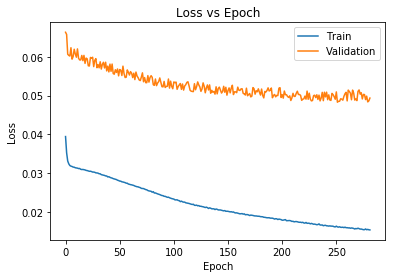

(3147, 74, 34, 1)
(3147, 74, 34, 1)
(1348, 74, 34, 1)
(1348, 74, 34, 1)
-------------------
[20]
bad


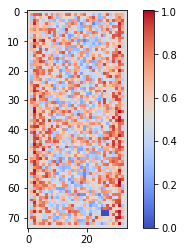

Reconstruction


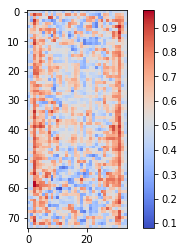

Distance


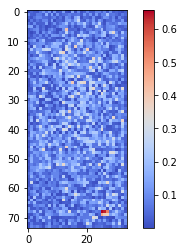

-------------------
[21]
bad


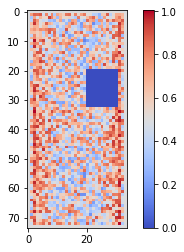

Reconstruction


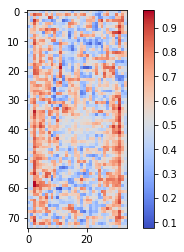

Distance


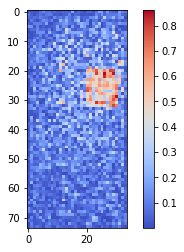

-------------------
[22]
bad


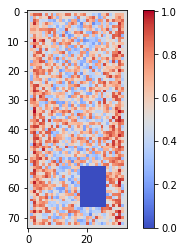

Reconstruction


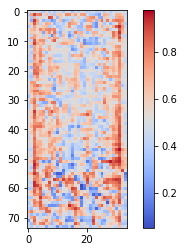

Distance


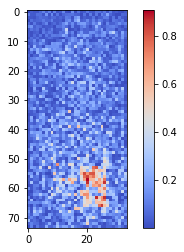

-------------------
[23]
bad


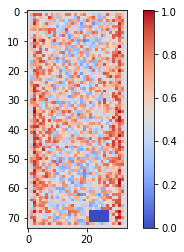

Reconstruction


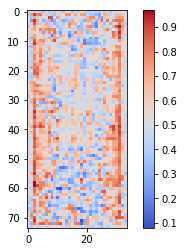

Distance


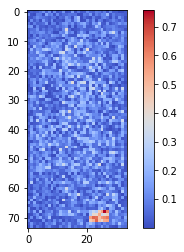

-------------------
[24]
good


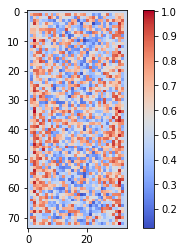

Reconstruction


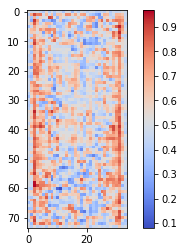

Distance


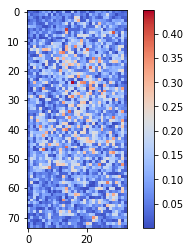

-------------------
[25]
bad


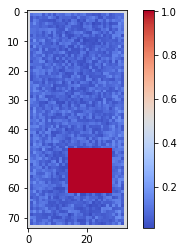

Reconstruction


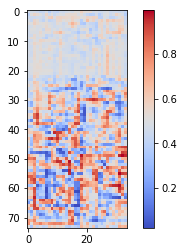

Distance


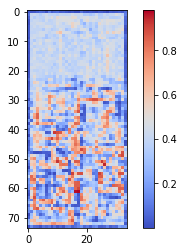

-------------------
[26]
bad


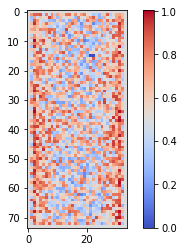

Reconstruction


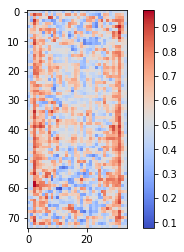

Distance


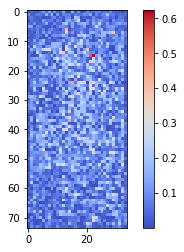

-------------------
[27]
bad


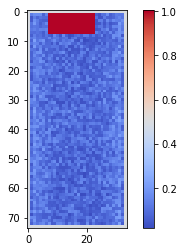

Reconstruction


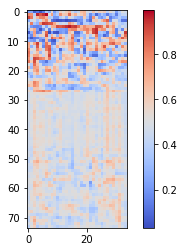

Distance


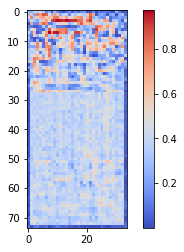

-------------------
[28]
bad


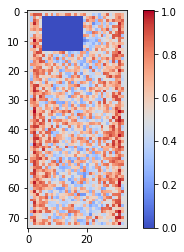

Reconstruction


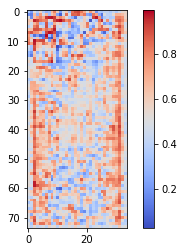

Distance


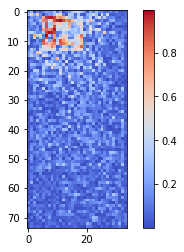

-------------------
[29]
good


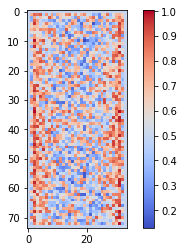

Reconstruction


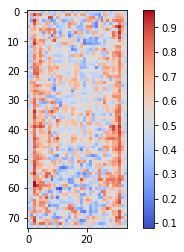

Distance


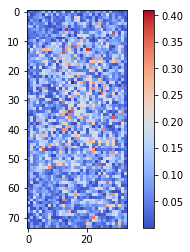

-------------------
[30]
bad


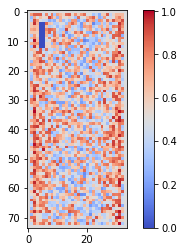

Reconstruction


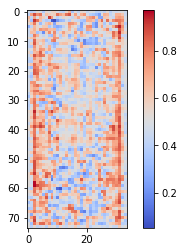

Distance


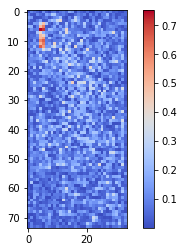

-------------------
[31]
good


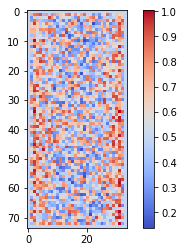

Reconstruction


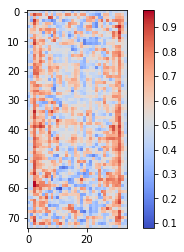

Distance


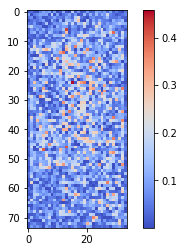

-------------------
[32]
good


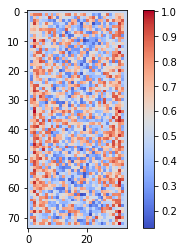

Reconstruction


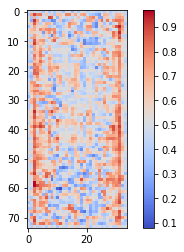

Distance


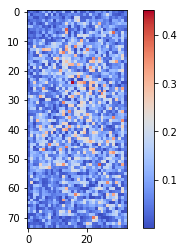

-------------------
[33]
good


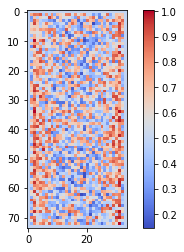

Reconstruction


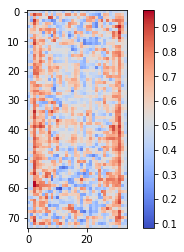

Distance


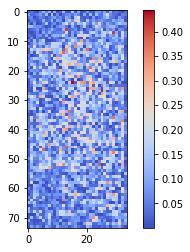

-------------------
[34]
bad


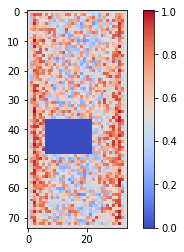

Reconstruction


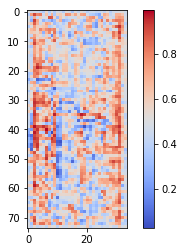

Distance


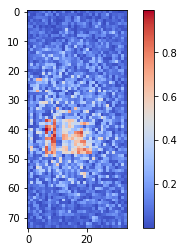

-------------------
[35]
good


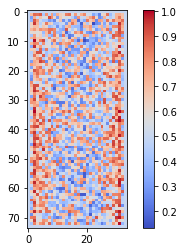

Reconstruction


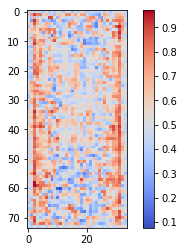

Distance


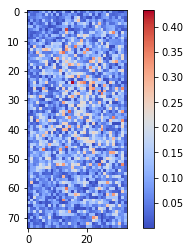

-------------------
[36]
bad


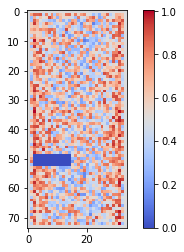

Reconstruction


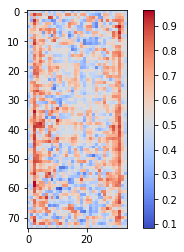

Distance


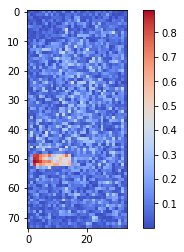

-------------------
[37]
bad


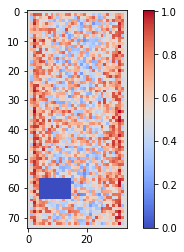

Reconstruction


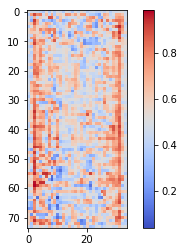

Distance


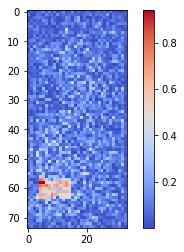

-------------------
[38]
bad


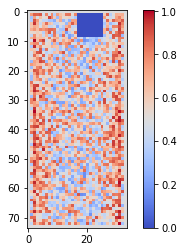

Reconstruction


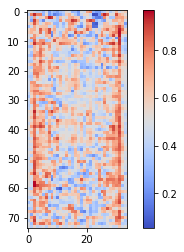

Distance


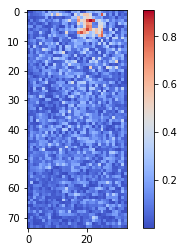

-------------------
[39]
good


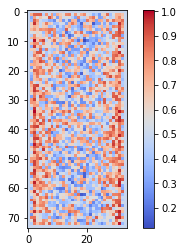

Reconstruction


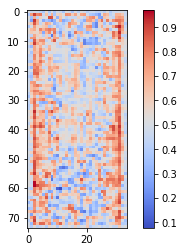

Distance


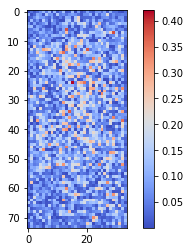

-------------------
[40]
bad


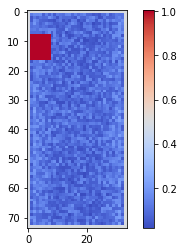

Reconstruction


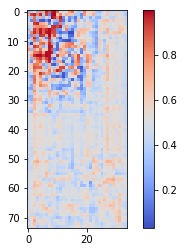

Distance


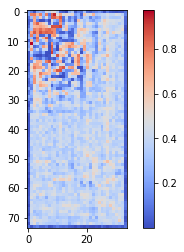

-------------------
[41]
bad


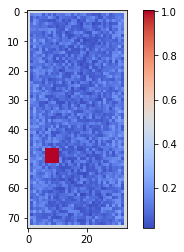

Reconstruction


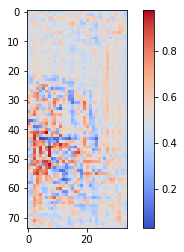

Distance


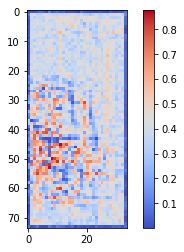

-------------------
[42]
bad


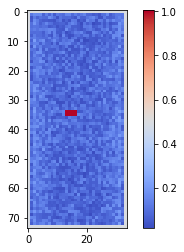

Reconstruction


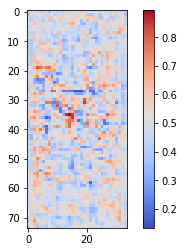

Distance


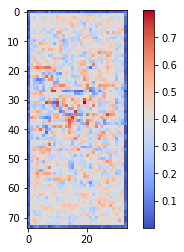

-------------------
[43]
bad


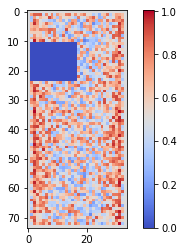

Reconstruction


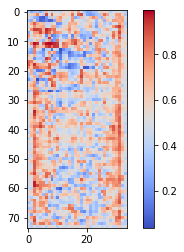

Distance


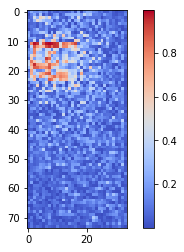

-------------------
[44]
bad


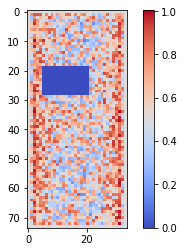

Reconstruction


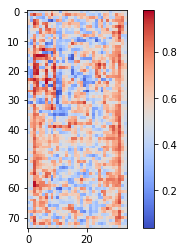

Distance


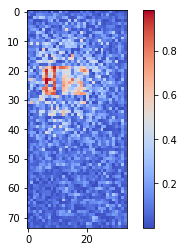

3147
1348


In [6]:
u.plot_loss(data=history,title="Loss vs Epoch",yscale='linear')

best_model= load_model(filepath='AE_random_best_model.hdf5')

pred = best_model.predict(Xtest)
diff = u.makedistancemap(pred,Xtest)
predval= best_model.predict(Xval)
diffval= u.makedistancemap(predval,Xval)

print pred.shape
print diff.shape
print predval.shape
print diffval.shape

for k in range(20,45):
    print'-------------------'
    print [k]
    print ytest[k]
    im=plt.imshow(np.reshape(Xtest,(Xtest.shape[0],Xtest.shape[1],Xtest.shape[2]))[k],cmap=cm.coolwarm)
    plt.colorbar()
    plt.show()
    plt.clf()
    print 'Reconstruction'
    im=plt.imshow(np.reshape(pred,(pred.shape[0],pred.shape[1],pred.shape[2]))[k],cmap=cm.coolwarm)
    plt.colorbar()
    plt.show()
    plt.clf()
    print 'Distance'
    im=plt.imshow(np.reshape(diff,(diff.shape[0],diff.shape[1],diff.shape[2]))[k],cmap=cm.coolwarm)
    plt.colorbar()
    plt.show()
    plt.clf()
    
maxerr=[]
for img in diff:
    maxerr.append(np.max(img))
    
print len(maxerr)
maxvalerr=[]
for img in diffval:
    maxvalerr.append(np.max(img))
    
print len(maxvalerr)

0.419968192564
0.54664782001
0.483308006287


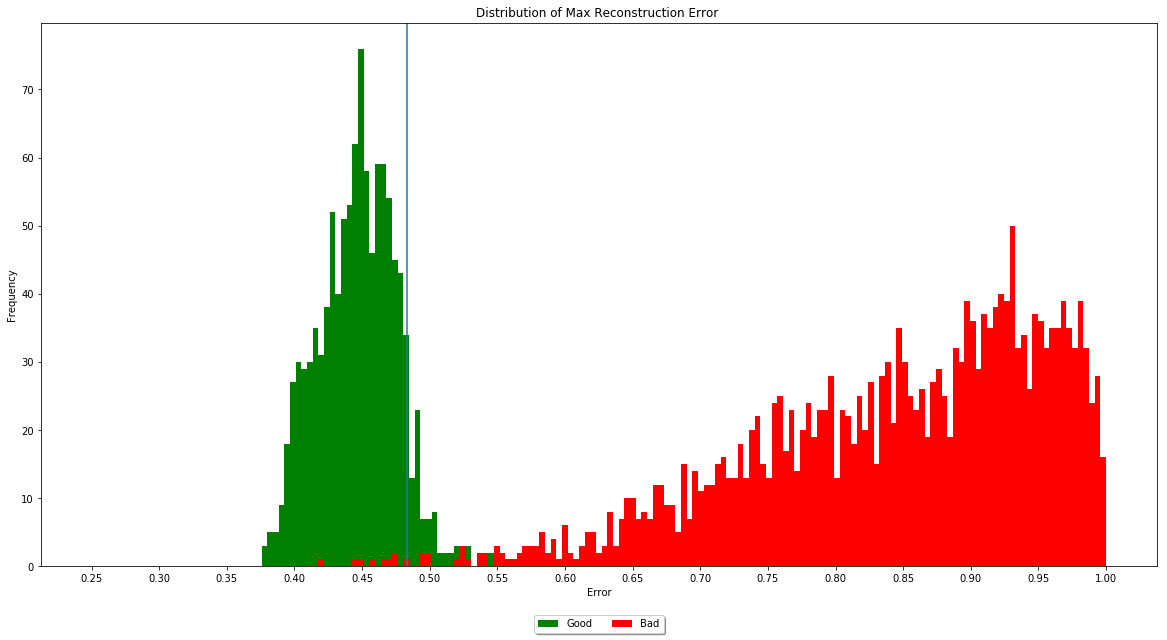

Text(0.5,1,u'Max Error per Reconstruction Image')

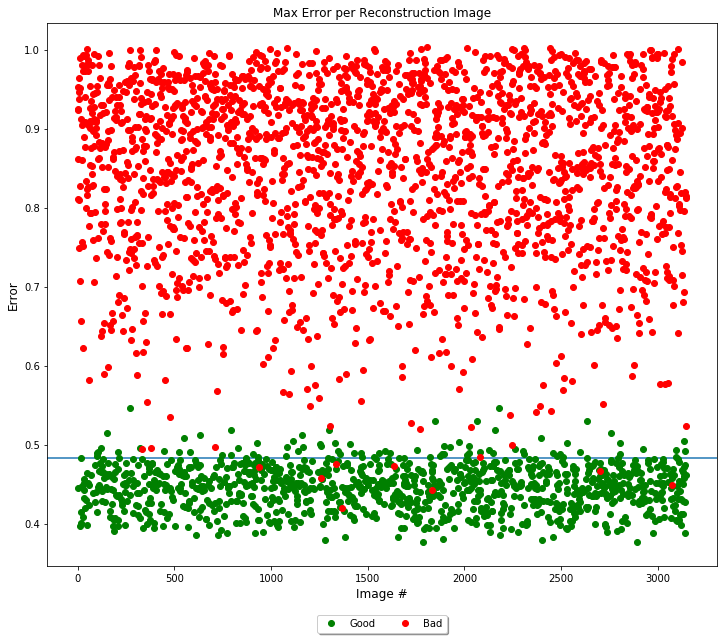

In [8]:
k=0
G=[]
H=[]
D=[]
Gv=[]
Hv=[]
Dv=[]
Gindexv=[]
Hindexv=[]
Dindexv=[]
Gindex=[]
Hindex=[]
Dindex=[]
while k<len(maxerr):
    if ytest[k]=='good':
        Gindex.append(k)
        G.append(maxerr[k])
        k=k+1
        
    else:
        Dindex.append(k)
        D.append(maxerr[k])
        k+=1
        
k=0
while k<len(maxvalerr):
    if yval[k]=='good':
        Gindexv.append(k)
        Gv.append(maxvalerr[k])
        k=k+1
        
    else:
        Dindexv.append(k)
        Dv.append(maxvalerr[k])
        k+=1
        
dmin=np.min(D)
print dmin
gmax=np.max(G)
print gmax
cut=np.mean([dmin,gmax])
print cut

start = .25
stop  = 1
step  = .05
bins=np.linspace(start, stop, num=180)

plt.figure(figsize=(20,10))

plt.hist(G,color='green',bins=bins,label='Good',rwidth=None)
plt.hist(D,color='red',bins=bins,label='Bad',rwidth=None)
#plt.hist(D,color='blue',bins=bins,label='Dead',rwidth=None,alpha=.4)

plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.08),  shadow=True, ncol=3)
plt.axvline(x=cut)
plt.xticks(np.arange(start, stop+step, step))

plt.xlabel('Error')
plt.ylabel('Frequency')
plt.title('Distribution of Max Reconstruction Error ')
plt.show()

plt.figure(figsize=(12,10))
#plt.plot(maxerr,'ko',label='All')
plt.axhline(y=cut)
plt.plot(Gindex,G,'go',label='Good')
#plt.plot(Hindex,H,'ro',label='Hot')
plt.plot(Dindex,D,'ro',label='Bad')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.08),  shadow=True, ncol=3)
plt.xlabel('Image #',fontsize='large')
plt.ylabel('Error',fontsize='large')
plt.title('Max Error per Reconstruction Image')